In [2]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D


# numericalization
from collections import Counter

# preprocessing
from string import punctuation
import re

# modeling
from sklearn.model_selection import train_test_split


# neural nets
import tensorflow as tf
from keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras import Sequential, Input, optimizers
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

pd.set_option('display.max_columns', 500)
title_fontsize = 15

In [103]:
import plotly.express as px
import plotly.graph_objects as go
from plotly import tools

In [247]:
sent_df = pd.read_csv('./data/balanced_tokenized_cleaned_stocktwits.csv', 
                 parse_dates=['created_at']).drop('body', axis=1)

stocks_df = pd.read_csv('./data/scraped_stock_2015_2022.csv', 
                        parse_dates=['Date']).iloc[:, 1:]

In [248]:
# find all indexes with tickers
df = sent_df['raw_content'].str.upper().str.extractall(r'\$(\w+)')[0].reset_index()

# remove indexes containing more than one ticker
df = sent_df.drop(df[df['match'] == 1]['level_0'].tolist())

# add ticker 
df['ticker'] = df['raw_content'].str.upper().str.extract(r'\$(\w+)')

# extract date only
df['Date'] = df['created_at'].dt.date

df['ticker'].unique()

array(['AAPL', 'AMZN', 'FB', 'NVDA', 'TSLA', 'AMZNGET', 'FBZUK',
       'AAPLSTAY', 'FB1', 'AAPLLOOKS'], dtype=object)

In [249]:
def clean_tickers(ticker):
    if 'AAPL' in ticker:
        ticker = 'AAPL'
    elif 'AMZN' in ticker:
        ticker = 'AMZN'
    elif 'FB' in ticker:
        ticker = 'META'
    else:
        ticker = ticker
        
    return ticker

df['ticker'] = df['ticker'].apply(lambda x: clean_tickers(x))

# get average sentiment per day
df = df.groupby(['ticker', 'Date']).agg({'sentiment': 'mean'}).reset_index()
df['Date'] = pd.to_datetime(df['Date'])

In [327]:
globals()[tick]['color'] = globals()[tick]['sentiment'].apply(lambda x: 'green' if x > 0.5 else 'red')

,Date,sentiment,Open,High,Low,Close,Adj Close,Volume,Stock Name,color
0,2019-12-24,0.642857,27.890667,28.364668,27.512667,28.350000,28.350000,120820500,TSLA,green
1,2019-12-26,0.353474,28.527332,28.898666,28.423332,28.729334,28.729334,159508500,TSLA,red
2,2019-12-27,0.477509,29.000000,29.020666,28.407333,28.691999,28.691999,149185500,TSLA,red
3,2019-12-30,0.333333,28.586000,28.600000,27.284000,27.646667,27.646667,188796000,TSLA,red
4,2019-12-31,0.436293,27.000000,28.086000,26.805332,27.888666,27.888666,154285500,TSLA,red
...,...,...,...,...,...,...,...,...,...,...
545,2022-02-23,0.217569,276.809998,278.433319,253.520004,254.679993,254.679993,95256900,TSLA,red
546,2022-02-24,0.313276,233.463333,267.493347,233.333328,266.923340,266.923340,135322200,TSLA,red
547,2022-02-25,0.517060,269.743347,273.166656,260.799988,269.956665,269.956665,76067700,TSLA,green
548,2022-02-28,0.486076,271.670013,292.286682,271.570007,290.143341,290.143341,99006900,TSLA,red


In [328]:
for tick in df['ticker'].unique():
    df1 = df[df['ticker'] == tick]
    df1 = df1['sentiment'].apply(lambda x: 'green' if x > 0.5 else 'red')
    df2 = stocks_df[stocks_df['Stock Name'] == tick]
    
    globals()[tick] = pd.merge(df1, df2, on='Date').iloc[:, 1:]
    globals()[tick]['color'] = globals()[tick]['sentiment'].apply(lambda x: 'green' if x > 0.5 else 'red')
    globals()[tick]['label'] = globals()[tick]['sentiment'].apply(lambda x: 'Bullish' if x > 0.5 else 'Bearish')
    
    
#test
AAPL

,Date,sentiment,Open,High,Low,Close,Adj Close,Volume,Stock Name,color
0,2019-12-31,0.428571,72.482498,73.419998,72.379997,73.412498,71.920578,100805600,AAPL,red
1,2020-01-02,0.563452,74.059998,75.150002,73.797501,75.087502,73.561539,135480400,AAPL,green
2,2020-01-03,0.357143,74.287498,75.144997,74.125000,74.357498,72.846375,146322800,AAPL,red
3,2020-01-06,0.433333,73.447502,74.989998,73.187500,74.949997,73.426819,118387200,AAPL,red
4,2020-01-07,0.409091,74.959999,75.224998,74.370003,74.597504,73.081497,108872000,AAPL,red
...,...,...,...,...,...,...,...,...,...,...
539,2022-02-18,0.215054,169.820007,170.539993,166.190002,167.300003,166.546555,82772700,AAPL,red
540,2022-02-22,0.526316,164.979996,166.690002,162.149994,164.320007,163.579987,91162800,AAPL,green
541,2022-02-23,0.378049,165.539993,166.149994,159.750000,160.070007,159.349121,90009200,AAPL,red
542,2022-02-24,0.443548,152.580002,162.850006,152.000000,162.740005,162.007095,141147500,AAPL,red


<AxesSubplot: ylabel='High'>

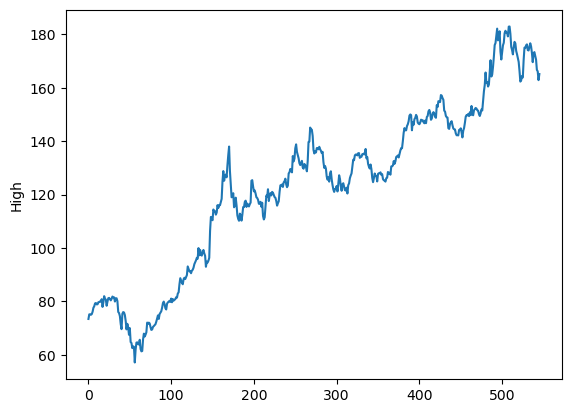

In [27]:
stocks_df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'Stock Name'],
      dtype='object')

In [194]:
df = stocks_df

In [26]:
stocks_df[stocks_df.Date.dt.year.between(2015, 2022)]

,Date,Open,High,Low,Close,Adj Close,Volume,Stock Name
0,2015-01-02,14.858000,14.883333,14.217333,14.620667,14.620667,71466000,TSLA
1,2015-01-05,14.303333,14.433333,13.810667,14.006000,14.006000,80527500,TSLA
2,2015-01-06,14.004000,14.280000,13.614000,14.085333,14.085333,93928500,TSLA
3,2015-01-07,14.223333,14.318667,13.985333,14.063333,14.063333,44526000,TSLA
4,2015-01-08,14.187333,14.253333,14.000667,14.041333,14.041333,51637500,TSLA
...,...,...,...,...,...,...,...,...
45435,2022-09-22,13.730000,14.600000,13.400000,13.740000,13.740000,23489400,XPEV
45436,2022-09-23,13.090000,13.892000,12.860000,13.710000,13.710000,28279600,XPEV
45437,2022-09-26,14.280000,14.830000,14.070000,14.370000,14.370000,27891300,XPEV
45438,2022-09-27,14.580000,14.800000,13.580000,13.710000,13.710000,21160800,XPEV


In [185]:
import plotly.express as px
import plotly.graph_objects as go

data = AAPL

# colors = []
# for i in range(1, len(data)):
#     if data['sentiment'][i] > 0.4:
#         colors.append("green")
#     else:
#         colors.append("red")

fig = go.Figure()

fig.add_trace(go.Scatter(x=data['Date'], y=data['sentiment'], name="Sentiment Score"))
fig.add_trace(go.Scatter(x=data['Date'], y=data['High'], name="Stock Price"))



# Update the layout to include a second y-axis and a legend
fig.update_layout(
    hovermode="x unified",
    yaxis2=dict(
        overlaying="y",
        side="right"
    ),
    legend=dict(
        x=0,
        y=1.05,
        traceorder="normal",
        font=dict(
            family="sans-serif",
            size=12,
            color="black"
        ),
    )
)

fig.show()


In [243]:
data.loc[data['sentiment'] < 0.5, 'color'] = 'red'

,Date,sentiment,Open,High,Low,Close,Adj Close,Volume,Stock Name
1,2020-01-02,0.563452,74.059998,75.150002,73.797501,75.087502,73.561539,135480400,AAPL
5,2020-01-08,0.610294,74.290001,76.110001,74.290001,75.797501,74.257095,132079200,AAPL
6,2020-01-09,0.543353,76.809998,77.607498,76.550003,77.407501,75.834396,170108400,AAPL
12,2020-01-17,0.523364,79.067497,79.684998,78.750000,79.682503,78.063141,137816400,AAPL
13,2020-01-21,0.618182,79.297501,79.754997,79.000000,79.142502,77.534126,110843200,AAPL
...,...,...,...,...,...,...,...,...,...
533,2022-02-08,0.653846,171.729996,175.350006,171.429993,174.830002,174.042633,74829200,AAPL
534,2022-02-09,0.507937,176.050003,176.649994,174.899994,176.279999,175.486099,71285000,AAPL
538,2022-02-15,0.532468,170.970001,172.949997,170.250000,172.789993,172.011826,62527400,AAPL
542,2022-02-22,0.526316,164.979996,166.690002,162.149994,164.320007,163.579987,91162800,AAPL


<AxesSubplot: xlabel='Date', ylabel='sentiment'>

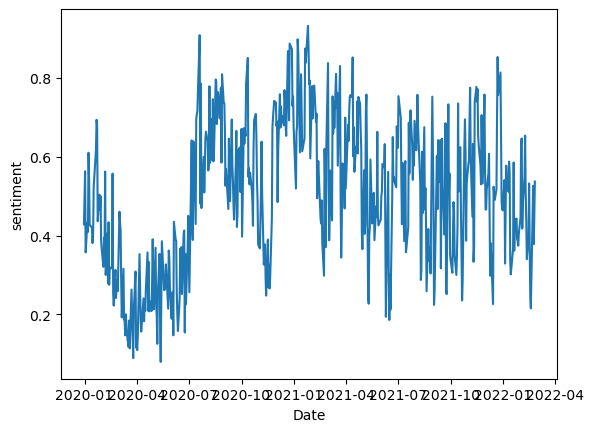

In [268]:
sns.plot(data, x='Date', y='sentiment')

In [288]:
import plotly.subplots as sp
import plotly.graph_objs as go

# Create subplot with two traces
fig = sp.make_subplots(rows=1, cols=2)
fig.add_trace(go.Scatter(x=[1, 2, 3], y=[4, 5, 6], name='Trace 1'))
fig.add_trace(go.Scatter(x=[1, 2, 3], y=[7, 8, 9], name='Trace 2'))

# Update x-axis labels
fig.update_xaxes(title_text="X-axis 1", row=1, col=1)
fig.update_xaxes(title_text="X-axis 2", row=1, col=2)

# Update y-axis labels
fig.update_yaxes(title_text="Y-axis 1", row=1, col=1)
fig.update_yaxes(title_text="Y-axis 2", row=1, col=2)

# Show plot
fig.show()

In [302]:
company = 'AAPL'

In [308]:
company

'AAPL'

,Date,sentiment,Open,High,Low,Close,Adj Close,Volume,Stock Name,color
0,2019-12-31,0.428571,72.482498,73.419998,72.379997,73.412498,71.920578,100805600,AAPL,red
1,2020-01-02,0.563452,74.059998,75.150002,73.797501,75.087502,73.561539,135480400,AAPL,green
2,2020-01-03,0.357143,74.287498,75.144997,74.125000,74.357498,72.846375,146322800,AAPL,red
3,2020-01-06,0.433333,73.447502,74.989998,73.187500,74.949997,73.426819,118387200,AAPL,red
4,2020-01-07,0.409091,74.959999,75.224998,74.370003,74.597504,73.081497,108872000,AAPL,red
...,...,...,...,...,...,...,...,...,...,...
539,2022-02-18,0.215054,169.820007,170.539993,166.190002,167.300003,166.546555,82772700,AAPL,red
540,2022-02-22,0.526316,164.979996,166.690002,162.149994,164.320007,163.579987,91162800,AAPL,green
541,2022-02-23,0.378049,165.539993,166.149994,159.750000,160.070007,159.349121,90009200,AAPL,red
542,2022-02-24,0.443548,152.580002,162.850006,152.000000,162.740005,162.007095,141147500,AAPL,red


In [312]:
AAPL

,Date,sentiment,Open,High,Low,Close,Adj Close,Volume,Stock Name,color
0,2019-12-31,0.428571,72.482498,73.419998,72.379997,73.412498,71.920578,100805600,AAPL,red
1,2020-01-02,0.563452,74.059998,75.150002,73.797501,75.087502,73.561539,135480400,AAPL,green
2,2020-01-03,0.357143,74.287498,75.144997,74.125000,74.357498,72.846375,146322800,AAPL,red
3,2020-01-06,0.433333,73.447502,74.989998,73.187500,74.949997,73.426819,118387200,AAPL,red
4,2020-01-07,0.409091,74.959999,75.224998,74.370003,74.597504,73.081497,108872000,AAPL,red
...,...,...,...,...,...,...,...,...,...,...
539,2022-02-18,0.215054,169.820007,170.539993,166.190002,167.300003,166.546555,82772700,AAPL,red
540,2022-02-22,0.526316,164.979996,166.690002,162.149994,164.320007,163.579987,91162800,AAPL,green
541,2022-02-23,0.378049,165.539993,166.149994,159.750000,160.070007,159.349121,90009200,AAPL,red
542,2022-02-24,0.443548,152.580002,162.850006,152.000000,162.740005,162.007095,141147500,AAPL,red


In [345]:
data = globals()[company]

# identify color grid
data['color'] = 'green'
data.loc[data['sentiment'] < 0.5, 'color'] = 'red'

fig = tools.make_subplots(rows=3, cols=1,

# create the plot grid
specs=[[{'rowspan': 2}],
       [None],
       [{'rowspan': 1}]],
       
vertical_spacing=0.05)
# horizontal_spacing=0.08)


stock = go.Scatter(x=data['Date'], y=data['Adj Close'], name="Adj. Close")
MA30 = go.Scatter(x=data['Date'], y=data['High'].rolling(window=30).mean(), name="30 day MA")
MA50 = go.Scatter(x=data['Date'], y=data['High'].rolling(window=50).mean(), name="50 day MA")
# MA200 = go.Scatter(x=data['Date'], y=data['High'].rolling(window=200).mean(), name="200 day MA")
sentiment = go.Bar(x=data['Date'], y=data['sentiment'], name="Sentiment", marker=dict(color=data['color'], line=dict(width=0)), showlegend=False)
fig.append_trace(stock, row=1, col=1)
fig.append_trace(MA30, row=1, col=1)
fig.append_trace(MA50, row=1, col=1)
# fig.append_trace(MA200, row=1, col=1)
fig.append_trace(sentiment, row=3, col=1)
fig.layout.update(title="My global title",
                     height=600, width=900, showlegend=True, hovermode='closest')

fig.update_layout(
    hovermode="x unified")

fig.update_traces(xaxis='x1')
fig.update_yaxes(title_text='Stock Price', row=1, col=1)
fig.update_yaxes(title_text='Sentiment', row=3, col=1)
    
fig.show()

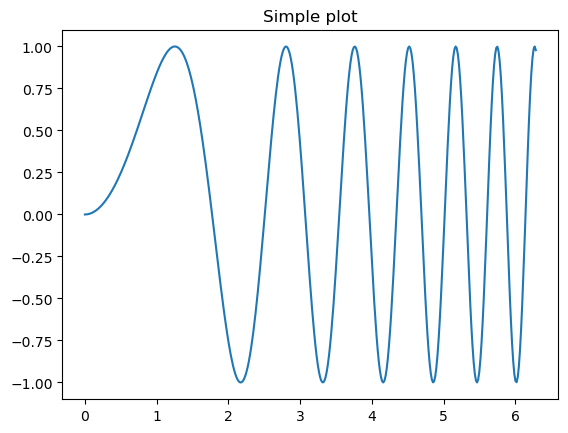

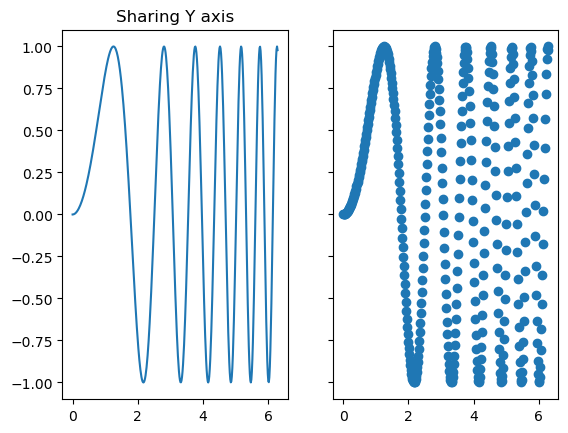

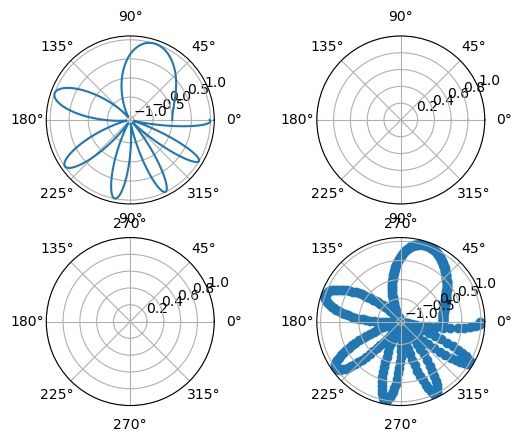

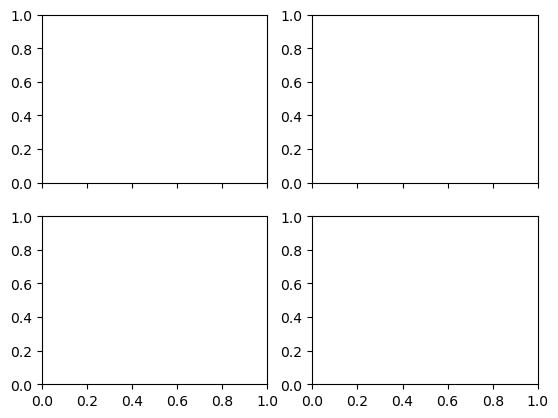

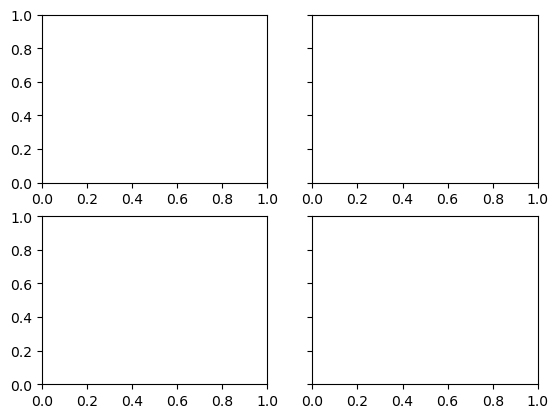

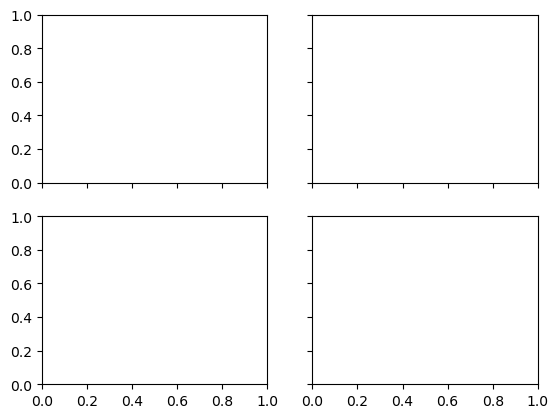

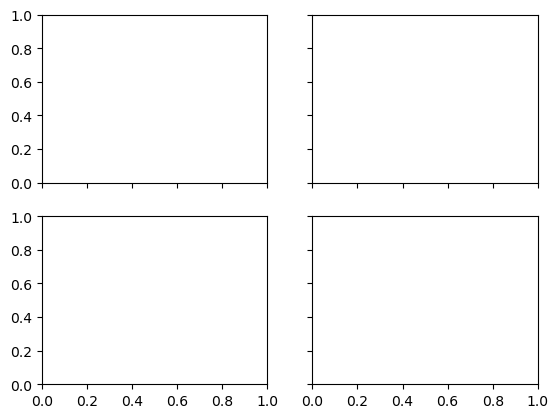

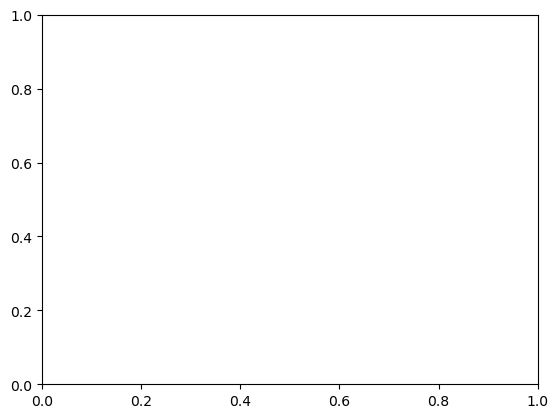

In [347]:
# First create some toy data:
x = np.linspace(0, 2*np.pi, 400)
y = np.sin(x**2)

# Create just a figure and only one subplot
fig, ax = plt.subplots()
ax.plot(x, y)
ax.set_title('Simple plot')

# Create two subplots and unpack the output array immediately
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.plot(x, y)
ax1.set_title('Sharing Y axis')
ax2.scatter(x, y)

# Create four polar axes and access them through the returned array
fig, axs = plt.subplots(2, 2, subplot_kw=dict(projection="polar"))
axs[0, 0].plot(x, y)
axs[1, 1].scatter(x, y)

# Share a X axis with each column of subplots
plt.subplots(2, 2, sharex='col')

# Share a Y axis with each row of subplots
plt.subplots(2, 2, sharey='row')

# Share both X and Y axes with all subplots
plt.subplots(2, 2, sharex='all', sharey='all')

# Note that this is the same as
plt.subplots(2, 2, sharex=True, sharey=True)

# Create figure number 10 with a single subplot
# and clears it if it already exists.
fig, ax = plt.subplots(num=10, clear=True)

In [92]:
AAPL

,Date,sentiment,Open,High,Low,Close,Adj Close,Volume,Stock Name
0,2019-12-31,0.428571,72.482498,73.419998,72.379997,73.412498,71.920578,100805600,AAPL
1,2020-01-02,0.563452,74.059998,75.150002,73.797501,75.087502,73.561539,135480400,AAPL
2,2020-01-03,0.357143,74.287498,75.144997,74.125000,74.357498,72.846375,146322800,AAPL
3,2020-01-06,0.433333,73.447502,74.989998,73.187500,74.949997,73.426819,118387200,AAPL
4,2020-01-07,0.409091,74.959999,75.224998,74.370003,74.597504,73.081497,108872000,AAPL
...,...,...,...,...,...,...,...,...,...
541,2022-02-18,0.215054,169.820007,170.539993,166.190002,167.300003,166.546555,82772700,AAPL
542,2022-02-22,0.526316,164.979996,166.690002,162.149994,164.320007,163.579987,91162800,AAPL
543,2022-02-23,0.378049,165.539993,166.149994,159.750000,160.070007,159.349121,90009200,AAPL
544,2022-02-24,0.443548,152.580002,162.850006,152.000000,162.740005,162.007095,141147500,AAPL


<AxesSubplot: ylabel='High'>

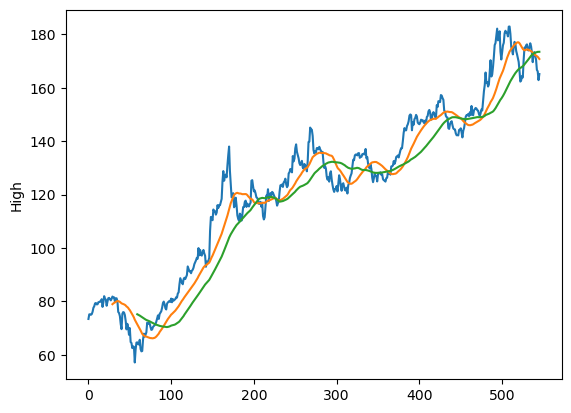

In [14]:
sns.lineplot(data=AAPL, x=AAPL.index, y='High')
AAPL['High'].rolling(window=30).mean().plot()
AAPL['High'].rolling(window=60).mean().plot()
# AAPL['sentiment'].rolling(window=30).mean().plot()

<AxesSubplot:>

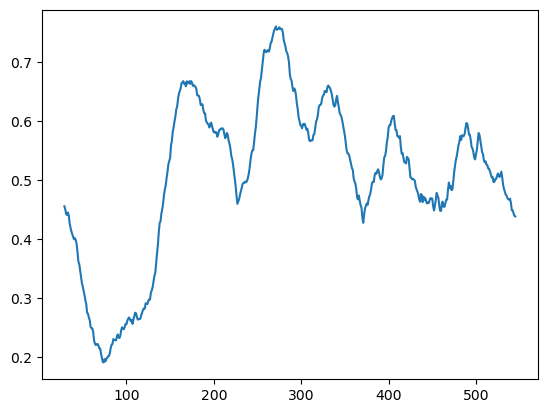

In [8]:
AAPL['sentiment'].rolling(window=30).mean().plot()

<AxesSubplot:>

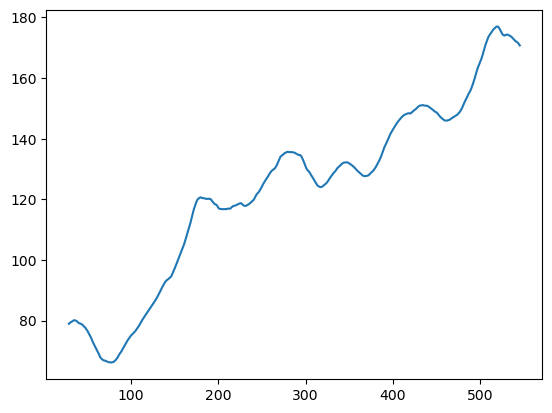

In [189]:
AAPL['High'].rolling(window=30).mean().plot()
# AAPL['sentiment'].rolling(window=30).mean().plot()

Text(0.5, 1.0, 'AAPL')

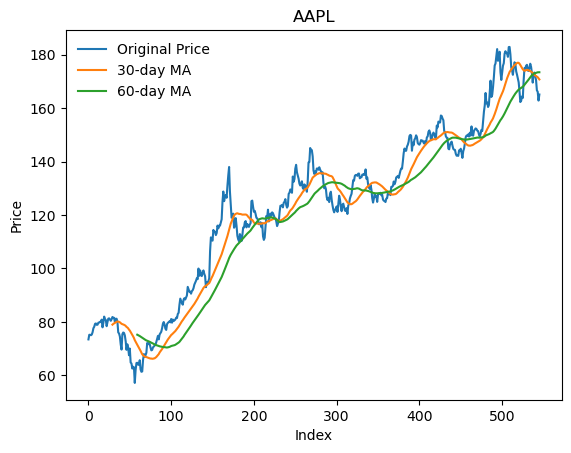

In [25]:
plt.plot(AAPL['High'], label='Original Price')
plt.plot(AAPL['High'].rolling(window=30).mean(), label='30-day MA')
plt.plot(AAPL['High'].rolling(window=60).mean(), label='60-day MA')
plt.legend(frameon=False)
plt.xlabel('Index')
plt.ylabel('Price')
plt.title('AAPL')

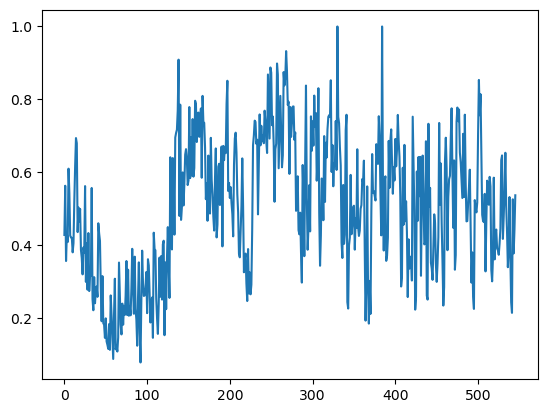

In [28]:
plt.plot(AAPL['sentiment'])

In [29]:
from sklearn.metrics import mean_squared_error,mean_absolute_error
from math import sqrt

def plot_predictions_with_dates(pred_type,twitter,dates,y_actual_lstm,y_pred_lstm):
    predicted_features=['Open','Adj Close']
    for i,predicted_feature in enumerate(predicted_features):
        plt.figure(figsize=(15,6))
        if twitter :
            plt.title(f'LSTM {pred_type} prediction of {predicted_feature} feature After adding twitter sentiment analysis')
        else:
            plt.title(f'LSTM {pred_type} prediction of {predicted_feature} feature without twitter sentiment analysis')
        sns.lineplot(x=dates, y=y_actual_lstm[:,i],label='Actual')
        sns.lineplot(x=dates, y=y_pred_lstm[:, i], label='Predicted')
        plt.show()
        error=mean_squared_error(y_actual_lstm[:,i], y_pred_lstm[:, i])
        print(f'Mean square error for {predicted_feature} ={error}')
    print('Total mean square error', mean_squared_error(y_actual_lstm, y_pred_lstm))

In [30]:
def build_model(input_shape):
    tf.random.set_seed(seed)
    cnn_lstm_model = Sequential()

    cnn_lstm_model.add(Conv1D(filters=128, kernel_size=2, strides=1, padding='valid', input_shape=input_shape))
    cnn_lstm_model.add(MaxPooling1D(pool_size=2, strides=2))

    cnn_lstm_model.add(Conv1D(filters=64, kernel_size=2, strides=1, padding='valid'))
    cnn_lstm_model.add(MaxPooling1D(pool_size=1, strides=2))
    # cnn_lstm_model.add(MaxPooling1D(pool_size=1, strides=2))

    cnn_lstm_model.add(Bidirectional(CuDNNLSTM(256, return_sequences=True)))
    cnn_lstm_model.add(Dropout(0.2))
    cnn_lstm_model.add(Bidirectional(CuDNNLSTM(256, return_sequences=True)))
    cnn_lstm_model.add(Dropout(0.2))

    cnn_lstm_model.add(Dense(32, activation='relu'))


    cnn_lstm_model.add(Dense(trainY.shape[2], activation='relu'))

    # cnn_lstm_model.build(input_shape=(trainX.shape[0], trainX.shape[1], trainX.shape[2]))

    cnn_lstm_model.compile(optimizer='adam', loss='mse')
    cnn_lstm_model.summary()
    return cnn_lstm_model